<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/V7_Tomato_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d manjuphoenix/tomatodataset

 98% 905M/923M [00:07<00:00, 99.2MB/s]
100% 923M/923M [00:07<00:00, 122MB/s] 


In [6]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.7)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a validation set is: 19488
The number of images in a test set is: 5856
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [9]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*64*64, 100)
        self.fc2 = nn.Linear(100, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()


In [10]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=8, bias=True)
)

In [11]:
class EarlyStopping():
  """ Early stopping is used to stop the training process to avoid overfitting of the model when the loss does not improve after certain epochs"""
  def __init__(self, patience=6, min_delta=0):
      """
      Parameters:
      Patience: Number of epochs to wait before stopping when the loss is not improving
      min_delta: Minimum difference between new loss and the old loss for new loss to be considered as an improvement
      """
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.best_loss = None
      self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print("INFO: Early Stopping")
        self.early_stop = True

In [12]:
from tqdm import tqdm

def train(model,loss_fn,dataloader,optimizer,epoch):
    print('\nEpoch : %d'%epoch)
    total_loss=0    
    correct=0
    total=0

    model.train()
    for data in tqdm(dataloader):
        inputs,labels=data[0].to(device),data[1].to(device)
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    loss=total_loss/len(dataloader)
    accuracy=100.*correct/total
    
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.4f | Accuracy: %.4f'%(loss,accuracy))
    return loss, accuracy

In [13]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()
    total_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= loss_fn(outputs,labels)
            total_loss+=loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        loss=total_loss/len(dataloader)
        accuracy=100.*correct/total
        losses['val'].append(loss)
        accuracies['val'].append(accuracy)
        print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 
    return loss, accuracy

In [14]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.00001

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6)

In [15]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=400
early_stopping = EarlyStopping()
for epoch in range(1,epochs+1): 
  train_loss, train_accuracy = train(model,loss_fn,train_loader,optimizer_ft,epoch)
  val_loss, val_accuracy = test(model,loss_fn,val_loader,epoch)
  early_stopping(val_loss)
  if early_stopping.early_stop:
    break


Epoch : 1


100%|██████████| 2841/2841 [01:48<00:00, 26.07it/s]


Train Loss: 2.0752 | Accuracy: 13.7125


100%|██████████| 609/609 [00:21<00:00, 28.17it/s]


Test Loss: 2.072 | Accuracy: 14.804

Epoch : 2


100%|██████████| 2841/2841 [01:40<00:00, 28.24it/s]


Train Loss: 2.0684 | Accuracy: 16.0268


100%|██████████| 609/609 [00:21<00:00, 27.70it/s]


Test Loss: 2.066 | Accuracy: 16.344

Epoch : 3


100%|██████████| 2841/2841 [01:41<00:00, 28.10it/s]


Train Loss: 2.0618 | Accuracy: 17.0267


100%|██████████| 609/609 [00:21<00:00, 27.93it/s]


Test Loss: 2.059 | Accuracy: 17.140

Epoch : 4


100%|██████████| 2841/2841 [01:40<00:00, 28.17it/s]


Train Loss: 2.0544 | Accuracy: 18.8967


100%|██████████| 609/609 [00:21<00:00, 27.92it/s]


Test Loss: 2.049 | Accuracy: 21.965

Epoch : 5


100%|██████████| 2841/2841 [01:41<00:00, 27.92it/s]


Train Loss: 2.0427 | Accuracy: 23.4958


100%|██████████| 609/609 [00:21<00:00, 27.77it/s]


Test Loss: 2.036 | Accuracy: 27.324

Epoch : 6


100%|██████████| 2841/2841 [01:41<00:00, 28.00it/s]


Train Loss: 2.0281 | Accuracy: 28.1905


100%|██████████| 609/609 [00:22<00:00, 27.46it/s]


Test Loss: 2.018 | Accuracy: 28.746

Epoch : 7


100%|██████████| 2841/2841 [01:41<00:00, 28.07it/s]


Train Loss: 2.0080 | Accuracy: 29.7525


100%|██████████| 609/609 [00:21<00:00, 27.85it/s]


Test Loss: 1.994 | Accuracy: 30.337

Epoch : 8


100%|██████████| 2841/2841 [01:41<00:00, 28.01it/s]


Train Loss: 1.9817 | Accuracy: 30.4389


100%|██████████| 609/609 [00:22<00:00, 27.62it/s]


Test Loss: 1.964 | Accuracy: 31.554

Epoch : 9


100%|██████████| 2841/2841 [01:42<00:00, 27.84it/s]


Train Loss: 1.9496 | Accuracy: 30.6215


100%|██████████| 609/609 [00:22<00:00, 27.42it/s]


Test Loss: 1.930 | Accuracy: 32.129

Epoch : 10


100%|██████████| 2841/2841 [01:41<00:00, 27.96it/s]


Train Loss: 1.9166 | Accuracy: 31.8106


100%|██████████| 609/609 [00:22<00:00, 27.60it/s]


Test Loss: 1.896 | Accuracy: 32.308

Epoch : 11


100%|██████████| 2841/2841 [01:40<00:00, 28.23it/s]


Train Loss: 1.8834 | Accuracy: 32.4904


100%|██████████| 609/609 [00:22<00:00, 27.46it/s]


Test Loss: 1.864 | Accuracy: 33.063

Epoch : 12


100%|██████████| 2841/2841 [01:41<00:00, 27.97it/s]


Train Loss: 1.8540 | Accuracy: 33.4012


100%|██████████| 609/609 [00:22<00:00, 27.54it/s]


Test Loss: 1.837 | Accuracy: 34.418

Epoch : 13


100%|██████████| 2841/2841 [01:42<00:00, 27.81it/s]


Train Loss: 1.8339 | Accuracy: 34.1602


100%|██████████| 609/609 [00:22<00:00, 26.96it/s]


Test Loss: 1.814 | Accuracy: 35.481

Epoch : 14


100%|██████████| 2841/2841 [01:41<00:00, 27.94it/s]


Train Loss: 1.8125 | Accuracy: 35.4900


100%|██████████| 609/609 [00:21<00:00, 27.91it/s]


Test Loss: 1.789 | Accuracy: 36.610

Epoch : 15


100%|██████████| 2841/2841 [01:41<00:00, 27.87it/s]


Train Loss: 1.7920 | Accuracy: 36.4107


100%|██████████| 609/609 [00:21<00:00, 27.97it/s]


Test Loss: 1.775 | Accuracy: 37.498

Epoch : 16


100%|██████████| 2841/2841 [01:41<00:00, 27.97it/s]


Train Loss: 1.7711 | Accuracy: 37.4172


100%|██████████| 609/609 [00:22<00:00, 27.36it/s]


Test Loss: 1.755 | Accuracy: 38.668

Epoch : 17


100%|██████████| 2841/2841 [01:41<00:00, 27.91it/s]


Train Loss: 1.7522 | Accuracy: 38.3753


100%|██████████| 609/609 [00:22<00:00, 27.59it/s]


Test Loss: 1.732 | Accuracy: 40.214

Epoch : 18


100%|██████████| 2841/2841 [01:41<00:00, 28.10it/s]


Train Loss: 1.7295 | Accuracy: 39.3774


100%|██████████| 609/609 [00:21<00:00, 27.87it/s]


Test Loss: 1.711 | Accuracy: 40.835

Epoch : 19


100%|██████████| 2841/2841 [01:42<00:00, 27.79it/s]


Train Loss: 1.7098 | Accuracy: 40.4246


100%|██████████| 609/609 [00:21<00:00, 27.73it/s]


Test Loss: 1.693 | Accuracy: 41.913

Epoch : 20


100%|██████████| 2841/2841 [01:42<00:00, 27.85it/s]


Train Loss: 1.6954 | Accuracy: 40.5236


100%|██████████| 609/609 [00:22<00:00, 27.38it/s]


Test Loss: 1.670 | Accuracy: 42.056

Epoch : 21


100%|██████████| 2841/2841 [01:43<00:00, 27.44it/s]


Train Loss: 1.6767 | Accuracy: 41.6379


100%|██████████| 609/609 [00:22<00:00, 27.05it/s]


Test Loss: 1.663 | Accuracy: 42.498

Epoch : 22


100%|██████████| 2841/2841 [01:43<00:00, 27.38it/s]


Train Loss: 1.6583 | Accuracy: 42.2044


100%|██████████| 609/609 [00:22<00:00, 27.48it/s]


Test Loss: 1.640 | Accuracy: 43.874

Epoch : 23


100%|██████████| 2841/2841 [01:43<00:00, 27.54it/s]


Train Loss: 1.6427 | Accuracy: 43.2021


100%|██████████| 609/609 [00:22<00:00, 27.00it/s]


Test Loss: 1.636 | Accuracy: 43.971

Epoch : 24


100%|██████████| 2841/2841 [01:43<00:00, 27.48it/s]


Train Loss: 1.6351 | Accuracy: 43.3187


100%|██████████| 609/609 [00:22<00:00, 27.35it/s]


Test Loss: 1.630 | Accuracy: 44.161

Epoch : 25


100%|██████████| 2841/2841 [01:43<00:00, 27.49it/s]


Train Loss: 1.6299 | Accuracy: 43.6696


100%|██████████| 609/609 [00:22<00:00, 26.96it/s]


Test Loss: 1.614 | Accuracy: 43.986

Epoch : 26


100%|██████████| 2841/2841 [01:43<00:00, 27.55it/s]


Train Loss: 1.6126 | Accuracy: 44.4550


100%|██████████| 609/609 [00:22<00:00, 27.55it/s]


Test Loss: 1.599 | Accuracy: 45.362

Epoch : 27


100%|██████████| 2841/2841 [01:44<00:00, 27.29it/s]


Train Loss: 1.6039 | Accuracy: 44.9181


100%|██████████| 609/609 [00:22<00:00, 27.46it/s]


Test Loss: 1.600 | Accuracy: 45.988
INFO: Early stopping counter 1 of 6

Epoch : 28


100%|██████████| 2841/2841 [01:44<00:00, 27.29it/s]


Train Loss: 1.5917 | Accuracy: 45.3272


100%|██████████| 609/609 [00:22<00:00, 26.99it/s]


Test Loss: 1.579 | Accuracy: 45.870

Epoch : 29


100%|██████████| 2841/2841 [01:44<00:00, 27.25it/s]


Train Loss: 1.5840 | Accuracy: 45.7375


100%|██████████| 609/609 [00:22<00:00, 27.06it/s]


Test Loss: 1.573 | Accuracy: 47.030

Epoch : 30


100%|██████████| 2841/2841 [01:43<00:00, 27.45it/s]


Train Loss: 1.5819 | Accuracy: 46.1214


100%|██████████| 609/609 [00:22<00:00, 27.38it/s]


Test Loss: 1.561 | Accuracy: 47.446

Epoch : 31


100%|██████████| 2841/2841 [01:43<00:00, 27.40it/s]


Train Loss: 1.5714 | Accuracy: 46.5295


100%|██████████| 609/609 [00:22<00:00, 27.05it/s]


Test Loss: 1.554 | Accuracy: 47.323

Epoch : 32


100%|██████████| 2841/2841 [01:44<00:00, 27.26it/s]


Train Loss: 1.5621 | Accuracy: 46.9013


100%|██████████| 609/609 [00:22<00:00, 26.85it/s]


Test Loss: 1.554 | Accuracy: 48.206
INFO: Early stopping counter 1 of 6

Epoch : 33


100%|██████████| 2841/2841 [01:43<00:00, 27.35it/s]


Train Loss: 1.5478 | Accuracy: 47.4106


100%|██████████| 609/609 [00:22<00:00, 26.65it/s]


Test Loss: 1.541 | Accuracy: 48.165

Epoch : 34


100%|██████████| 2841/2841 [01:43<00:00, 27.40it/s]


Train Loss: 1.5426 | Accuracy: 47.7912


100%|██████████| 609/609 [00:22<00:00, 27.10it/s]


Test Loss: 1.533 | Accuracy: 48.827

Epoch : 35


100%|██████████| 2841/2841 [01:43<00:00, 27.37it/s]


Train Loss: 1.5259 | Accuracy: 48.3709


100%|██████████| 609/609 [00:22<00:00, 26.92it/s]


Test Loss: 1.520 | Accuracy: 49.115

Epoch : 36


100%|██████████| 2841/2841 [01:44<00:00, 27.25it/s]


Train Loss: 1.5229 | Accuracy: 48.4138


100%|██████████| 609/609 [00:22<00:00, 27.24it/s]


Test Loss: 1.512 | Accuracy: 49.746

Epoch : 37


100%|██████████| 2841/2841 [01:43<00:00, 27.35it/s]


Train Loss: 1.5078 | Accuracy: 49.1167


100%|██████████| 609/609 [00:22<00:00, 27.05it/s]


Test Loss: 1.506 | Accuracy: 49.597

Epoch : 38


100%|██████████| 2841/2841 [01:41<00:00, 27.94it/s]


Train Loss: 1.4953 | Accuracy: 49.7250


100%|██████████| 609/609 [00:21<00:00, 28.03it/s]


Test Loss: 1.493 | Accuracy: 50.588

Epoch : 39


100%|██████████| 2841/2841 [01:42<00:00, 27.78it/s]


Train Loss: 1.4846 | Accuracy: 50.1639


100%|██████████| 609/609 [00:22<00:00, 27.54it/s]


Test Loss: 1.479 | Accuracy: 49.659

Epoch : 40


100%|██████████| 2841/2841 [01:42<00:00, 27.75it/s]


Train Loss: 1.4732 | Accuracy: 50.3234


100%|██████████| 609/609 [00:22<00:00, 27.51it/s]


Test Loss: 1.464 | Accuracy: 51.019

Epoch : 41


100%|██████████| 2841/2841 [01:41<00:00, 27.88it/s]


Train Loss: 1.4596 | Accuracy: 50.8107


100%|██████████| 609/609 [00:21<00:00, 27.75it/s]


Test Loss: 1.446 | Accuracy: 51.481

Epoch : 42


100%|██████████| 2841/2841 [01:42<00:00, 27.78it/s]


Train Loss: 1.4497 | Accuracy: 51.3211


100%|██████████| 609/609 [00:22<00:00, 27.51it/s]


Test Loss: 1.434 | Accuracy: 52.369

Epoch : 43


100%|██████████| 2841/2841 [01:41<00:00, 27.87it/s]


Train Loss: 1.4309 | Accuracy: 51.8777


100%|██████████| 609/609 [00:22<00:00, 27.46it/s]


Test Loss: 1.422 | Accuracy: 51.229

Epoch : 44


100%|██████████| 2841/2841 [01:42<00:00, 27.67it/s]


Train Loss: 1.4229 | Accuracy: 52.2165


100%|██████████| 609/609 [00:22<00:00, 27.37it/s]


Test Loss: 1.417 | Accuracy: 53.493

Epoch : 45


100%|██████████| 2841/2841 [01:42<00:00, 27.80it/s]


Train Loss: 1.4121 | Accuracy: 52.4948


100%|██████████| 609/609 [00:22<00:00, 27.13it/s]


Test Loss: 1.407 | Accuracy: 52.390

Epoch : 46


100%|██████████| 2841/2841 [01:42<00:00, 27.61it/s]


Train Loss: 1.3930 | Accuracy: 53.3979


100%|██████████| 609/609 [00:22<00:00, 27.32it/s]


Test Loss: 1.380 | Accuracy: 54.006

Epoch : 47


100%|██████████| 2841/2841 [01:44<00:00, 27.29it/s]


Train Loss: 1.3760 | Accuracy: 53.5343


100%|██████████| 609/609 [00:22<00:00, 27.27it/s]


Test Loss: 1.367 | Accuracy: 54.977

Epoch : 48


100%|██████████| 2841/2841 [01:43<00:00, 27.33it/s]


Train Loss: 1.3633 | Accuracy: 54.0370


100%|██████████| 609/609 [00:22<00:00, 26.94it/s]


Test Loss: 1.352 | Accuracy: 54.843

Epoch : 49


100%|██████████| 2841/2841 [01:43<00:00, 27.47it/s]


Train Loss: 1.3513 | Accuracy: 54.3285


100%|██████████| 609/609 [00:22<00:00, 27.22it/s]


Test Loss: 1.348 | Accuracy: 54.597

Epoch : 50


100%|██████████| 2841/2841 [01:42<00:00, 27.77it/s]


Train Loss: 1.3398 | Accuracy: 54.5760


100%|██████████| 609/609 [00:22<00:00, 27.53it/s]


Test Loss: 1.323 | Accuracy: 55.906

Epoch : 51


100%|██████████| 2841/2841 [01:42<00:00, 27.66it/s]


Train Loss: 1.3239 | Accuracy: 55.1028


100%|██████████| 609/609 [00:22<00:00, 27.64it/s]


Test Loss: 1.316 | Accuracy: 55.706

Epoch : 52


100%|██████████| 2841/2841 [01:42<00:00, 27.68it/s]


Train Loss: 1.3143 | Accuracy: 55.3085


100%|██████████| 609/609 [00:22<00:00, 27.59it/s]


Test Loss: 1.311 | Accuracy: 55.490

Epoch : 53


100%|██████████| 2841/2841 [01:42<00:00, 27.80it/s]


Train Loss: 1.2973 | Accuracy: 55.9146


100%|██████████| 609/609 [00:22<00:00, 27.62it/s]


Test Loss: 1.290 | Accuracy: 55.536

Epoch : 54


100%|██████████| 2841/2841 [01:43<00:00, 27.42it/s]


Train Loss: 1.2814 | Accuracy: 56.4107


100%|██████████| 609/609 [00:22<00:00, 27.22it/s]


Test Loss: 1.283 | Accuracy: 55.906

Epoch : 55


100%|██████████| 2841/2841 [01:43<00:00, 27.47it/s]


Train Loss: 1.2732 | Accuracy: 56.6065


100%|██████████| 609/609 [00:22<00:00, 26.57it/s]


Test Loss: 1.271 | Accuracy: 56.902

Epoch : 56


100%|██████████| 2841/2841 [01:45<00:00, 27.04it/s]


Train Loss: 1.2597 | Accuracy: 56.7924


100%|██████████| 609/609 [00:22<00:00, 26.53it/s]


Test Loss: 1.256 | Accuracy: 57.323

Epoch : 57


100%|██████████| 2841/2841 [01:43<00:00, 27.49it/s]


Train Loss: 1.2513 | Accuracy: 57.0762


100%|██████████| 609/609 [00:22<00:00, 26.75it/s]


Test Loss: 1.247 | Accuracy: 57.189

Epoch : 58


100%|██████████| 2841/2841 [01:43<00:00, 27.43it/s]


Train Loss: 1.2315 | Accuracy: 57.6064


100%|██████████| 609/609 [00:22<00:00, 27.02it/s]


Test Loss: 1.230 | Accuracy: 57.897

Epoch : 59


100%|██████████| 2841/2841 [01:44<00:00, 27.27it/s]


Train Loss: 1.2300 | Accuracy: 57.4645


100%|██████████| 609/609 [00:22<00:00, 27.07it/s]


Test Loss: 1.220 | Accuracy: 58.062

Epoch : 60


100%|██████████| 2841/2841 [01:43<00:00, 27.35it/s]


Train Loss: 1.2081 | Accuracy: 58.4149


100%|██████████| 609/609 [00:22<00:00, 27.08it/s]


Test Loss: 1.219 | Accuracy: 58.159

Epoch : 61


100%|██████████| 2841/2841 [01:43<00:00, 27.32it/s]


Train Loss: 1.2115 | Accuracy: 58.2180


100%|██████████| 609/609 [00:22<00:00, 27.21it/s]


Test Loss: 1.200 | Accuracy: 58.970

Epoch : 62


100%|██████████| 2841/2841 [01:44<00:00, 27.25it/s]


Train Loss: 1.1955 | Accuracy: 58.7141


100%|██████████| 609/609 [00:22<00:00, 27.11it/s]


Test Loss: 1.202 | Accuracy: 58.883
INFO: Early stopping counter 1 of 6

Epoch : 63


100%|██████████| 2841/2841 [01:44<00:00, 27.17it/s]


Train Loss: 1.1906 | Accuracy: 58.8846


100%|██████████| 609/609 [00:22<00:00, 27.05it/s]


Test Loss: 1.186 | Accuracy: 59.566

Epoch : 64


100%|██████████| 2841/2841 [01:44<00:00, 27.16it/s]


Train Loss: 1.1757 | Accuracy: 59.6271


100%|██████████| 609/609 [00:22<00:00, 26.87it/s]


Test Loss: 1.172 | Accuracy: 59.566

Epoch : 65


100%|██████████| 2841/2841 [01:44<00:00, 27.24it/s]


Train Loss: 1.1686 | Accuracy: 59.6469


100%|██████████| 609/609 [00:22<00:00, 26.78it/s]


Test Loss: 1.168 | Accuracy: 59.648

Epoch : 66


100%|██████████| 2841/2841 [01:44<00:00, 27.30it/s]


Train Loss: 1.1567 | Accuracy: 60.0077


100%|██████████| 609/609 [00:22<00:00, 26.81it/s]


Test Loss: 1.156 | Accuracy: 60.130

Epoch : 67


100%|██████████| 2841/2841 [01:45<00:00, 27.00it/s]


Train Loss: 1.1514 | Accuracy: 60.1155


100%|██████████| 609/609 [00:22<00:00, 26.83it/s]


Test Loss: 1.153 | Accuracy: 60.146

Epoch : 68


100%|██████████| 2841/2841 [01:44<00:00, 27.24it/s]


Train Loss: 1.1414 | Accuracy: 60.4389


100%|██████████| 609/609 [00:22<00:00, 26.59it/s]


Test Loss: 1.142 | Accuracy: 59.992

Epoch : 69


100%|██████████| 2841/2841 [01:44<00:00, 27.13it/s]


Train Loss: 1.1274 | Accuracy: 60.8866


100%|██████████| 609/609 [00:22<00:00, 27.06it/s]


Test Loss: 1.149 | Accuracy: 60.059
INFO: Early stopping counter 1 of 6

Epoch : 70


100%|██████████| 2841/2841 [01:45<00:00, 26.91it/s]


Train Loss: 1.1199 | Accuracy: 61.4740


100%|██████████| 609/609 [00:22<00:00, 27.22it/s]


Test Loss: 1.124 | Accuracy: 61.486

Epoch : 71


100%|██████████| 2841/2841 [01:44<00:00, 27.12it/s]


Train Loss: 1.1169 | Accuracy: 61.3761


100%|██████████| 609/609 [00:22<00:00, 26.97it/s]


Test Loss: 1.124 | Accuracy: 61.070

Epoch : 72


100%|██████████| 2841/2841 [01:44<00:00, 27.20it/s]


Train Loss: 1.1050 | Accuracy: 61.6753


100%|██████████| 609/609 [00:22<00:00, 26.67it/s]


Test Loss: 1.110 | Accuracy: 61.660

Epoch : 73


100%|██████████| 2841/2841 [01:44<00:00, 27.16it/s]


Train Loss: 1.1070 | Accuracy: 61.6214


100%|██████████| 609/609 [00:23<00:00, 26.47it/s]


Test Loss: 1.099 | Accuracy: 62.137

Epoch : 74


100%|██████████| 2841/2841 [01:44<00:00, 27.17it/s]


Train Loss: 1.0963 | Accuracy: 62.3298


100%|██████████| 609/609 [00:22<00:00, 26.73it/s]


Test Loss: 1.089 | Accuracy: 62.877

Epoch : 75


100%|██████████| 2841/2841 [01:46<00:00, 26.79it/s]


Train Loss: 1.0886 | Accuracy: 62.3837


100%|██████████| 609/609 [00:23<00:00, 26.24it/s]


Test Loss: 1.093 | Accuracy: 62.009
INFO: Early stopping counter 1 of 6

Epoch : 76


100%|██████████| 2841/2841 [01:45<00:00, 26.90it/s]


Train Loss: 1.0790 | Accuracy: 62.5344


100%|██████████| 609/609 [00:22<00:00, 26.74it/s]


Test Loss: 1.079 | Accuracy: 62.877

Epoch : 77


100%|██████████| 2841/2841 [01:46<00:00, 26.74it/s]


Train Loss: 1.0747 | Accuracy: 62.7819


100%|██████████| 609/609 [00:22<00:00, 27.05it/s]


Test Loss: 1.068 | Accuracy: 63.046

Epoch : 78


100%|██████████| 2841/2841 [01:44<00:00, 27.24it/s]


Train Loss: 1.0646 | Accuracy: 63.0217


100%|██████████| 609/609 [00:22<00:00, 27.20it/s]


Test Loss: 1.080 | Accuracy: 62.338
INFO: Early stopping counter 1 of 6

Epoch : 79


100%|██████████| 2841/2841 [01:43<00:00, 27.36it/s]


Train Loss: 1.0603 | Accuracy: 63.3495


100%|██████████| 609/609 [00:22<00:00, 27.36it/s]


Test Loss: 1.067 | Accuracy: 63.246

Epoch : 80


100%|██████████| 2841/2841 [01:45<00:00, 26.87it/s]


Train Loss: 1.0542 | Accuracy: 63.2912


100%|██████████| 609/609 [00:22<00:00, 26.88it/s]


Test Loss: 1.054 | Accuracy: 64.021

Epoch : 81


100%|██████████| 2841/2841 [01:45<00:00, 26.82it/s]


Train Loss: 1.0478 | Accuracy: 63.7598


100%|██████████| 609/609 [00:23<00:00, 26.46it/s]


Test Loss: 1.052 | Accuracy: 63.308

Epoch : 82


100%|██████████| 2841/2841 [01:46<00:00, 26.61it/s]


Train Loss: 1.0392 | Accuracy: 63.9556


100%|██████████| 609/609 [00:22<00:00, 26.59it/s]


Test Loss: 1.047 | Accuracy: 64.396

Epoch : 83


100%|██████████| 2841/2841 [01:44<00:00, 27.06it/s]


Train Loss: 1.0334 | Accuracy: 64.1393


100%|██████████| 609/609 [00:22<00:00, 26.76it/s]


Test Loss: 1.040 | Accuracy: 64.637

Epoch : 84


100%|██████████| 2841/2841 [01:45<00:00, 26.92it/s]


Train Loss: 1.0264 | Accuracy: 64.3681


100%|██████████| 609/609 [00:22<00:00, 26.65it/s]


Test Loss: 1.035 | Accuracy: 64.165

Epoch : 85


100%|██████████| 2841/2841 [01:45<00:00, 27.03it/s]


Train Loss: 1.0260 | Accuracy: 64.2592


100%|██████████| 609/609 [00:22<00:00, 26.78it/s]


Test Loss: 1.052 | Accuracy: 63.061
INFO: Early stopping counter 1 of 6

Epoch : 86


100%|██████████| 2841/2841 [01:46<00:00, 26.68it/s]


Train Loss: 1.0241 | Accuracy: 64.2108


100%|██████████| 609/609 [00:23<00:00, 26.48it/s]


Test Loss: 1.016 | Accuracy: 65.084

Epoch : 87


100%|██████████| 2841/2841 [01:46<00:00, 26.75it/s]


Train Loss: 1.0125 | Accuracy: 64.8246


100%|██████████| 609/609 [00:23<00:00, 26.34it/s]


Test Loss: 1.014 | Accuracy: 65.197

Epoch : 88


100%|██████████| 2841/2841 [01:45<00:00, 26.84it/s]


Train Loss: 1.0127 | Accuracy: 64.8499


100%|██████████| 609/609 [00:22<00:00, 26.57it/s]


Test Loss: 1.007 | Accuracy: 65.459

Epoch : 89


100%|██████████| 2841/2841 [01:45<00:00, 26.99it/s]


Train Loss: 1.0008 | Accuracy: 65.3140


100%|██████████| 609/609 [00:22<00:00, 26.53it/s]


Test Loss: 1.005 | Accuracy: 65.428

Epoch : 90


100%|██████████| 2841/2841 [01:45<00:00, 26.84it/s]


Train Loss: 0.9933 | Accuracy: 65.3195


100%|██████████| 609/609 [00:23<00:00, 26.36it/s]


Test Loss: 0.998 | Accuracy: 65.777

Epoch : 91


100%|██████████| 2841/2841 [01:46<00:00, 26.74it/s]


Train Loss: 0.9946 | Accuracy: 65.4438


100%|██████████| 609/609 [00:22<00:00, 26.67it/s]


Test Loss: 0.995 | Accuracy: 66.100

Epoch : 92


100%|██████████| 2841/2841 [01:45<00:00, 26.89it/s]


Train Loss: 0.9822 | Accuracy: 65.8409


100%|██████████| 609/609 [00:22<00:00, 26.60it/s]


Test Loss: 0.989 | Accuracy: 65.910

Epoch : 93


100%|██████████| 2841/2841 [01:45<00:00, 26.87it/s]


Train Loss: 0.9736 | Accuracy: 66.2666


100%|██████████| 609/609 [00:23<00:00, 26.41it/s]


Test Loss: 0.984 | Accuracy: 66.054

Epoch : 94


100%|██████████| 2841/2841 [01:46<00:00, 26.72it/s]


Train Loss: 0.9724 | Accuracy: 66.1775


100%|██████████| 609/609 [00:23<00:00, 26.42it/s]


Test Loss: 0.975 | Accuracy: 66.680

Epoch : 95


100%|██████████| 2841/2841 [01:45<00:00, 26.83it/s]


Train Loss: 0.9665 | Accuracy: 66.6582


100%|██████████| 609/609 [00:22<00:00, 26.80it/s]


Test Loss: 0.970 | Accuracy: 66.721

Epoch : 96


100%|██████████| 2841/2841 [01:46<00:00, 26.78it/s]


Train Loss: 0.9679 | Accuracy: 66.3942


100%|██████████| 609/609 [00:22<00:00, 26.55it/s]


Test Loss: 0.970 | Accuracy: 66.398
INFO: Early stopping counter 1 of 6

Epoch : 97


100%|██████████| 2841/2841 [01:45<00:00, 26.82it/s]


Train Loss: 0.9616 | Accuracy: 66.5262


100%|██████████| 609/609 [00:22<00:00, 26.80it/s]


Test Loss: 0.959 | Accuracy: 67.035

Epoch : 98


100%|██████████| 2841/2841 [01:46<00:00, 26.77it/s]


Train Loss: 0.9521 | Accuracy: 66.9409


100%|██████████| 609/609 [00:22<00:00, 27.21it/s]


Test Loss: 0.960 | Accuracy: 67.260
INFO: Early stopping counter 1 of 6

Epoch : 99


100%|██████████| 2841/2841 [01:45<00:00, 26.87it/s]


Train Loss: 0.9479 | Accuracy: 67.0949


100%|██████████| 609/609 [00:22<00:00, 26.49it/s]


Test Loss: 0.950 | Accuracy: 67.491

Epoch : 100


100%|██████████| 2841/2841 [01:45<00:00, 27.00it/s]


Train Loss: 0.9467 | Accuracy: 67.2665


100%|██████████| 609/609 [00:23<00:00, 25.97it/s]


Test Loss: 0.951 | Accuracy: 67.178
INFO: Early stopping counter 1 of 6

Epoch : 101


100%|██████████| 2841/2841 [01:44<00:00, 27.12it/s]


Train Loss: 0.9432 | Accuracy: 66.9717


100%|██████████| 609/609 [00:23<00:00, 26.16it/s]


Test Loss: 0.948 | Accuracy: 67.399

Epoch : 102


100%|██████████| 2841/2841 [01:44<00:00, 27.20it/s]


Train Loss: 0.9331 | Accuracy: 67.3600


100%|██████████| 609/609 [00:23<00:00, 26.39it/s]


Test Loss: 0.941 | Accuracy: 67.455

Epoch : 103


100%|██████████| 2841/2841 [01:45<00:00, 26.99it/s]


Train Loss: 0.9304 | Accuracy: 67.4931


100%|██████████| 609/609 [00:22<00:00, 26.58it/s]


Test Loss: 0.956 | Accuracy: 67.050
INFO: Early stopping counter 1 of 6

Epoch : 104


100%|██████████| 2841/2841 [01:46<00:00, 26.71it/s]


Train Loss: 0.9268 | Accuracy: 67.7637


100%|██████████| 609/609 [00:23<00:00, 26.44it/s]


Test Loss: 0.932 | Accuracy: 68.077

Epoch : 105


100%|██████████| 2841/2841 [01:45<00:00, 26.85it/s]


Train Loss: 0.9229 | Accuracy: 67.7032


100%|██████████| 609/609 [00:22<00:00, 26.70it/s]


Test Loss: 0.924 | Accuracy: 67.923

Epoch : 106


100%|██████████| 2841/2841 [01:45<00:00, 26.88it/s]


Train Loss: 0.9178 | Accuracy: 67.8726


100%|██████████| 609/609 [00:22<00:00, 26.52it/s]


Test Loss: 0.920 | Accuracy: 68.118

Epoch : 107


100%|██████████| 2841/2841 [01:46<00:00, 26.58it/s]


Train Loss: 0.9113 | Accuracy: 68.0849


100%|██████████| 609/609 [00:22<00:00, 26.54it/s]


Test Loss: 0.919 | Accuracy: 68.590

Epoch : 108


100%|██████████| 2841/2841 [01:46<00:00, 26.75it/s]


Train Loss: 0.9083 | Accuracy: 68.2895


100%|██████████| 609/609 [00:22<00:00, 26.58it/s]


Test Loss: 0.918 | Accuracy: 68.349

Epoch : 109


100%|██████████| 2841/2841 [01:46<00:00, 26.60it/s]


Train Loss: 0.8994 | Accuracy: 68.6041


100%|██████████| 609/609 [00:23<00:00, 26.18it/s]


Test Loss: 0.905 | Accuracy: 68.641

Epoch : 110


100%|██████████| 2841/2841 [01:45<00:00, 26.81it/s]


Train Loss: 0.8949 | Accuracy: 68.8164


100%|██████████| 609/609 [00:23<00:00, 26.33it/s]


Test Loss: 0.909 | Accuracy: 68.431
INFO: Early stopping counter 1 of 6

Epoch : 111


100%|██████████| 2841/2841 [01:45<00:00, 26.84it/s]


Train Loss: 0.8980 | Accuracy: 68.6525


100%|██████████| 609/609 [00:22<00:00, 26.89it/s]


Test Loss: 0.901 | Accuracy: 68.749

Epoch : 112


100%|██████████| 2841/2841 [01:45<00:00, 27.04it/s]


Train Loss: 0.8896 | Accuracy: 68.7361


100%|██████████| 609/609 [00:22<00:00, 26.95it/s]


Test Loss: 0.896 | Accuracy: 68.970

Epoch : 113


100%|██████████| 2841/2841 [01:44<00:00, 27.13it/s]


Train Loss: 0.8859 | Accuracy: 68.9781


100%|██████████| 609/609 [00:22<00:00, 27.10it/s]


Test Loss: 0.894 | Accuracy: 68.893

Epoch : 114


100%|██████████| 2841/2841 [01:44<00:00, 27.18it/s]


Train Loss: 0.8831 | Accuracy: 69.0562


100%|██████████| 609/609 [00:22<00:00, 27.11it/s]


Test Loss: 0.884 | Accuracy: 69.375

Epoch : 115


100%|██████████| 2841/2841 [01:44<00:00, 27.08it/s]


Train Loss: 0.8801 | Accuracy: 69.0848


100%|██████████| 609/609 [00:22<00:00, 26.91it/s]


Test Loss: 0.879 | Accuracy: 69.540

Epoch : 116


100%|██████████| 2841/2841 [01:44<00:00, 27.25it/s]


Train Loss: 0.8793 | Accuracy: 69.2586


100%|██████████| 609/609 [00:22<00:00, 26.57it/s]


Test Loss: 0.888 | Accuracy: 69.067
INFO: Early stopping counter 1 of 6

Epoch : 117


100%|██████████| 2841/2841 [01:44<00:00, 27.25it/s]


Train Loss: 0.8755 | Accuracy: 69.3290


100%|██████████| 609/609 [00:23<00:00, 26.47it/s]


Test Loss: 0.883 | Accuracy: 69.447
INFO: Early stopping counter 2 of 6

Epoch : 118


100%|██████████| 2841/2841 [01:44<00:00, 27.18it/s]


Train Loss: 0.8698 | Accuracy: 69.5413


100%|██████████| 609/609 [00:22<00:00, 27.02it/s]


Test Loss: 0.877 | Accuracy: 69.314

Epoch : 119


100%|██████████| 2841/2841 [01:46<00:00, 26.75it/s]


Train Loss: 0.8672 | Accuracy: 69.5490


100%|██████████| 609/609 [00:22<00:00, 26.74it/s]


Test Loss: 0.867 | Accuracy: 69.724

Epoch : 120


100%|██████████| 2841/2841 [01:45<00:00, 26.87it/s]


Train Loss: 0.8600 | Accuracy: 69.9065


100%|██████████| 609/609 [00:22<00:00, 26.55it/s]


Test Loss: 0.881 | Accuracy: 69.437
INFO: Early stopping counter 1 of 6

Epoch : 121


100%|██████████| 2841/2841 [01:46<00:00, 26.71it/s]


Train Loss: 0.8585 | Accuracy: 69.8537


100%|██████████| 609/609 [00:22<00:00, 26.77it/s]


Test Loss: 0.863 | Accuracy: 69.837

Epoch : 122


100%|██████████| 2841/2841 [01:44<00:00, 27.14it/s]


Train Loss: 0.8535 | Accuracy: 69.8460


100%|██████████| 609/609 [00:22<00:00, 26.81it/s]


Test Loss: 0.856 | Accuracy: 70.238

Epoch : 123


100%|██████████| 2841/2841 [01:45<00:00, 26.82it/s]


Train Loss: 0.8488 | Accuracy: 70.1991


100%|██████████| 609/609 [00:22<00:00, 26.67it/s]


Test Loss: 0.858 | Accuracy: 70.150
INFO: Early stopping counter 1 of 6

Epoch : 124


100%|██████████| 2841/2841 [01:44<00:00, 27.16it/s]


Train Loss: 0.8454 | Accuracy: 70.2981


100%|██████████| 609/609 [00:22<00:00, 26.78it/s]


Test Loss: 0.848 | Accuracy: 70.520

Epoch : 125


100%|██████████| 2841/2841 [01:45<00:00, 27.01it/s]


Train Loss: 0.8509 | Accuracy: 69.9241


100%|██████████| 609/609 [00:22<00:00, 26.89it/s]


Test Loss: 0.844 | Accuracy: 70.828

Epoch : 126


100%|██████████| 2841/2841 [01:45<00:00, 26.91it/s]


Train Loss: 0.8436 | Accuracy: 70.4422


100%|██████████| 609/609 [00:22<00:00, 26.49it/s]


Test Loss: 0.852 | Accuracy: 70.535
INFO: Early stopping counter 1 of 6

Epoch : 127


100%|██████████| 2841/2841 [01:44<00:00, 27.28it/s]


Train Loss: 0.8367 | Accuracy: 70.3322


100%|██████████| 609/609 [00:22<00:00, 26.85it/s]


Test Loss: 0.849 | Accuracy: 70.535
INFO: Early stopping counter 2 of 6

Epoch : 128


100%|██████████| 2841/2841 [01:44<00:00, 27.26it/s]


Train Loss: 0.8420 | Accuracy: 70.3531


100%|██████████| 609/609 [00:22<00:00, 26.74it/s]


Test Loss: 0.840 | Accuracy: 70.936

Epoch : 129


100%|██████████| 2841/2841 [01:44<00:00, 27.26it/s]


Train Loss: 0.8349 | Accuracy: 70.5918


100%|██████████| 609/609 [00:22<00:00, 26.99it/s]


Test Loss: 0.839 | Accuracy: 70.772

Epoch : 130


100%|██████████| 2841/2841 [01:43<00:00, 27.33it/s]


Train Loss: 0.8260 | Accuracy: 70.9097


100%|██████████| 609/609 [00:22<00:00, 26.71it/s]


Test Loss: 0.833 | Accuracy: 71.090

Epoch : 131


100%|██████████| 2841/2841 [01:45<00:00, 27.03it/s]


Train Loss: 0.8284 | Accuracy: 70.8635


100%|██████████| 609/609 [00:23<00:00, 26.25it/s]


Test Loss: 0.828 | Accuracy: 71.023

Epoch : 132


100%|██████████| 2841/2841 [01:46<00:00, 26.58it/s]


Train Loss: 0.8258 | Accuracy: 71.2078


100%|██████████| 609/609 [00:23<00:00, 25.57it/s]


Test Loss: 0.829 | Accuracy: 71.254
INFO: Early stopping counter 1 of 6

Epoch : 133


100%|██████████| 2841/2841 [01:47<00:00, 26.33it/s]


Train Loss: 0.8212 | Accuracy: 70.9977


100%|██████████| 609/609 [00:23<00:00, 26.28it/s]


Test Loss: 0.827 | Accuracy: 71.311

Epoch : 134


100%|██████████| 2841/2841 [01:47<00:00, 26.39it/s]


Train Loss: 0.8240 | Accuracy: 70.9207


100%|██████████| 609/609 [00:22<00:00, 26.50it/s]


Test Loss: 0.820 | Accuracy: 71.521

Epoch : 135


100%|██████████| 2841/2841 [01:43<00:00, 27.38it/s]


Train Loss: 0.8163 | Accuracy: 71.2276


100%|██████████| 609/609 [00:22<00:00, 27.26it/s]


Test Loss: 0.827 | Accuracy: 71.331
INFO: Early stopping counter 1 of 6

Epoch : 136


100%|██████████| 2841/2841 [01:44<00:00, 27.08it/s]


Train Loss: 0.8158 | Accuracy: 71.2100


100%|██████████| 609/609 [00:23<00:00, 26.46it/s]


Test Loss: 0.828 | Accuracy: 71.311
INFO: Early stopping counter 2 of 6

Epoch : 137


100%|██████████| 2841/2841 [01:46<00:00, 26.57it/s]


Train Loss: 0.8164 | Accuracy: 71.2903


100%|██████████| 609/609 [00:23<00:00, 26.43it/s]


Test Loss: 0.810 | Accuracy: 72.003

Epoch : 138


100%|██████████| 2841/2841 [01:47<00:00, 26.42it/s]


Train Loss: 0.8083 | Accuracy: 71.4927


100%|██████████| 609/609 [00:23<00:00, 26.35it/s]


Test Loss: 0.815 | Accuracy: 71.778
INFO: Early stopping counter 1 of 6

Epoch : 139


100%|██████████| 2841/2841 [01:47<00:00, 26.42it/s]


Train Loss: 0.8045 | Accuracy: 71.5807


100%|██████████| 609/609 [00:23<00:00, 26.42it/s]


Test Loss: 0.820 | Accuracy: 71.434
INFO: Early stopping counter 2 of 6

Epoch : 140


100%|██████████| 2841/2841 [01:46<00:00, 26.64it/s]


Train Loss: 0.7993 | Accuracy: 71.7248


100%|██████████| 609/609 [00:23<00:00, 26.20it/s]


Test Loss: 0.815 | Accuracy: 71.752
INFO: Early stopping counter 3 of 6

Epoch : 141


100%|██████████| 2841/2841 [01:48<00:00, 26.15it/s]


Train Loss: 0.8020 | Accuracy: 71.8524


100%|██████████| 609/609 [00:23<00:00, 25.80it/s]


Test Loss: 0.804 | Accuracy: 72.039

Epoch : 142


100%|██████████| 2841/2841 [01:52<00:00, 25.23it/s]


Train Loss: 0.7977 | Accuracy: 71.9976


100%|██████████| 609/609 [00:25<00:00, 24.04it/s]


Test Loss: 0.803 | Accuracy: 72.265

Epoch : 143


100%|██████████| 2841/2841 [01:55<00:00, 24.55it/s]


Train Loss: 0.7930 | Accuracy: 72.1065


100%|██████████| 609/609 [00:25<00:00, 24.00it/s]


Test Loss: 0.804 | Accuracy: 71.865
INFO: Early stopping counter 1 of 6

Epoch : 144


100%|██████████| 2841/2841 [01:53<00:00, 25.13it/s]


Train Loss: 0.7951 | Accuracy: 72.1538


100%|██████████| 609/609 [00:22<00:00, 27.37it/s]


Test Loss: 0.804 | Accuracy: 71.783
INFO: Early stopping counter 2 of 6

Epoch : 145


100%|██████████| 2841/2841 [01:43<00:00, 27.36it/s]


Train Loss: 0.7922 | Accuracy: 72.0779


100%|██████████| 609/609 [00:22<00:00, 27.50it/s]


Test Loss: 0.798 | Accuracy: 72.440

Epoch : 146


100%|██████████| 2841/2841 [01:43<00:00, 27.49it/s]


Train Loss: 0.7881 | Accuracy: 72.1395


100%|██████████| 609/609 [00:22<00:00, 27.08it/s]


Test Loss: 0.792 | Accuracy: 72.537

Epoch : 147


100%|██████████| 2841/2841 [01:43<00:00, 27.35it/s]


Train Loss: 0.7864 | Accuracy: 72.2231


100%|██████████| 609/609 [00:22<00:00, 27.16it/s]


Test Loss: 0.792 | Accuracy: 72.589

Epoch : 148


100%|██████████| 2841/2841 [01:43<00:00, 27.53it/s]


Train Loss: 0.7880 | Accuracy: 72.2407


100%|██████████| 609/609 [00:22<00:00, 27.20it/s]


Test Loss: 0.787 | Accuracy: 73.071

Epoch : 149


100%|██████████| 2841/2841 [01:43<00:00, 27.50it/s]


Train Loss: 0.7834 | Accuracy: 72.1956


100%|██████████| 609/609 [00:22<00:00, 26.82it/s]


Test Loss: 0.782 | Accuracy: 72.984

Epoch : 150


100%|██████████| 2841/2841 [01:44<00:00, 27.15it/s]


Train Loss: 0.7769 | Accuracy: 72.6895


100%|██████████| 609/609 [00:22<00:00, 26.94it/s]


Test Loss: 0.785 | Accuracy: 72.753
INFO: Early stopping counter 1 of 6

Epoch : 151


100%|██████████| 2841/2841 [01:44<00:00, 27.17it/s]


Train Loss: 0.7809 | Accuracy: 72.4222


100%|██████████| 609/609 [00:22<00:00, 26.94it/s]


Test Loss: 0.778 | Accuracy: 72.912

Epoch : 152


100%|██████████| 2841/2841 [01:44<00:00, 27.19it/s]


Train Loss: 0.7748 | Accuracy: 72.6510


100%|██████████| 609/609 [00:22<00:00, 27.48it/s]


Test Loss: 0.777 | Accuracy: 73.102

Epoch : 153


100%|██████████| 2841/2841 [01:43<00:00, 27.52it/s]


Train Loss: 0.7671 | Accuracy: 72.9469


100%|██████████| 609/609 [00:22<00:00, 27.28it/s]


Test Loss: 0.804 | Accuracy: 71.772
INFO: Early stopping counter 1 of 6

Epoch : 154


100%|██████████| 2841/2841 [01:43<00:00, 27.51it/s]


Train Loss: 0.7660 | Accuracy: 72.9568


100%|██████████| 609/609 [00:22<00:00, 27.04it/s]


Test Loss: 0.776 | Accuracy: 73.087

Epoch : 155


100%|██████████| 2841/2841 [01:43<00:00, 27.55it/s]


Train Loss: 0.7648 | Accuracy: 73.0459


100%|██████████| 609/609 [00:22<00:00, 27.22it/s]


Test Loss: 0.779 | Accuracy: 73.020
INFO: Early stopping counter 1 of 6

Epoch : 156


100%|██████████| 2841/2841 [01:43<00:00, 27.48it/s]


Train Loss: 0.7651 | Accuracy: 72.9381


100%|██████████| 609/609 [00:22<00:00, 27.18it/s]


Test Loss: 0.769 | Accuracy: 73.574

Epoch : 157


100%|██████████| 2841/2841 [01:43<00:00, 27.53it/s]


Train Loss: 0.7621 | Accuracy: 73.1757


100%|██████████| 609/609 [00:22<00:00, 26.73it/s]


Test Loss: 0.772 | Accuracy: 73.112
INFO: Early stopping counter 1 of 6

Epoch : 158


100%|██████████| 2841/2841 [01:42<00:00, 27.65it/s]


Train Loss: 0.7643 | Accuracy: 73.0547


100%|██████████| 609/609 [00:22<00:00, 26.57it/s]


Test Loss: 0.767 | Accuracy: 73.133

Epoch : 159


100%|██████████| 2841/2841 [01:43<00:00, 27.38it/s]


Train Loss: 0.7612 | Accuracy: 73.2692


100%|██████████| 609/609 [00:22<00:00, 27.09it/s]


Test Loss: 0.784 | Accuracy: 72.388
INFO: Early stopping counter 1 of 6

Epoch : 160


100%|██████████| 2841/2841 [01:44<00:00, 27.28it/s]


Train Loss: 0.7669 | Accuracy: 72.8908


100%|██████████| 609/609 [00:22<00:00, 26.92it/s]


Test Loss: 0.767 | Accuracy: 73.348
INFO: Early stopping counter 2 of 6

Epoch : 161


100%|██████████| 2841/2841 [01:43<00:00, 27.38it/s]


Train Loss: 0.7565 | Accuracy: 73.2065


100%|██████████| 609/609 [00:22<00:00, 26.89it/s]


Test Loss: 0.757 | Accuracy: 73.446

Epoch : 162


100%|██████████| 2841/2841 [01:44<00:00, 27.31it/s]


Train Loss: 0.7601 | Accuracy: 73.3550


100%|██████████| 609/609 [00:22<00:00, 26.91it/s]


Test Loss: 0.755 | Accuracy: 73.733

Epoch : 163


100%|██████████| 2841/2841 [01:44<00:00, 27.27it/s]


Train Loss: 0.7515 | Accuracy: 73.4760


100%|██████████| 609/609 [00:22<00:00, 26.98it/s]


Test Loss: 0.756 | Accuracy: 74.011
INFO: Early stopping counter 1 of 6

Epoch : 164


100%|██████████| 2841/2841 [01:44<00:00, 27.26it/s]


Train Loss: 0.7532 | Accuracy: 73.3814


100%|██████████| 609/609 [00:22<00:00, 26.76it/s]


Test Loss: 0.757 | Accuracy: 73.780
INFO: Early stopping counter 2 of 6

Epoch : 165


100%|██████████| 2841/2841 [01:44<00:00, 27.26it/s]


Train Loss: 0.7465 | Accuracy: 73.6762


100%|██████████| 609/609 [00:22<00:00, 26.81it/s]


Test Loss: 0.755 | Accuracy: 73.708
INFO: Early stopping counter 3 of 6

Epoch : 166


100%|██████████| 2841/2841 [01:43<00:00, 27.34it/s]


Train Loss: 0.7399 | Accuracy: 73.9677


100%|██████████| 609/609 [00:22<00:00, 27.16it/s]


Test Loss: 0.749 | Accuracy: 74.139

Epoch : 167


100%|██████████| 2841/2841 [01:43<00:00, 27.42it/s]


Train Loss: 0.7461 | Accuracy: 73.8225


100%|██████████| 609/609 [00:22<00:00, 27.34it/s]


Test Loss: 0.752 | Accuracy: 73.667
INFO: Early stopping counter 1 of 6

Epoch : 168


100%|██████████| 2841/2841 [01:43<00:00, 27.49it/s]


Train Loss: 0.7399 | Accuracy: 73.9391


100%|██████████| 609/609 [00:22<00:00, 27.14it/s]


Test Loss: 0.764 | Accuracy: 73.400
INFO: Early stopping counter 2 of 6

Epoch : 169


100%|██████████| 2841/2841 [01:42<00:00, 27.67it/s]


Train Loss: 0.7339 | Accuracy: 74.2614


100%|██████████| 609/609 [00:22<00:00, 27.59it/s]


Test Loss: 0.746 | Accuracy: 74.437

Epoch : 170


100%|██████████| 2841/2841 [01:43<00:00, 27.41it/s]


Train Loss: 0.7408 | Accuracy: 73.9677


100%|██████████| 609/609 [00:22<00:00, 27.13it/s]


Test Loss: 0.748 | Accuracy: 74.077
INFO: Early stopping counter 1 of 6

Epoch : 171


100%|██████████| 2841/2841 [01:43<00:00, 27.35it/s]


Train Loss: 0.7412 | Accuracy: 73.7697


100%|██████████| 609/609 [00:22<00:00, 27.49it/s]


Test Loss: 0.744 | Accuracy: 74.144

Epoch : 172


100%|██████████| 2841/2841 [01:44<00:00, 27.27it/s]


Train Loss: 0.7362 | Accuracy: 74.1822


100%|██████████| 609/609 [00:22<00:00, 26.82it/s]


Test Loss: 0.739 | Accuracy: 74.159

Epoch : 173


100%|██████████| 2841/2841 [01:44<00:00, 27.23it/s]


Train Loss: 0.7292 | Accuracy: 74.3461


100%|██████████| 609/609 [00:22<00:00, 26.98it/s]


Test Loss: 0.757 | Accuracy: 73.769
INFO: Early stopping counter 1 of 6

Epoch : 174


100%|██████████| 2841/2841 [01:44<00:00, 27.15it/s]


Train Loss: 0.7310 | Accuracy: 74.2647


100%|██████████| 609/609 [00:22<00:00, 26.73it/s]


Test Loss: 0.733 | Accuracy: 74.421

Epoch : 175


100%|██████████| 2841/2841 [01:45<00:00, 26.93it/s]


Train Loss: 0.7286 | Accuracy: 74.3571


100%|██████████| 609/609 [00:22<00:00, 27.02it/s]


Test Loss: 0.764 | Accuracy: 73.287
INFO: Early stopping counter 1 of 6

Epoch : 176


100%|██████████| 2841/2841 [01:43<00:00, 27.48it/s]


Train Loss: 0.7318 | Accuracy: 74.2515


100%|██████████| 609/609 [00:22<00:00, 26.69it/s]


Test Loss: 0.733 | Accuracy: 74.478
INFO: Early stopping counter 2 of 6

Epoch : 177


100%|██████████| 2841/2841 [01:43<00:00, 27.39it/s]


Train Loss: 0.7276 | Accuracy: 74.3054


100%|██████████| 609/609 [00:22<00:00, 26.82it/s]


Test Loss: 0.741 | Accuracy: 74.262
INFO: Early stopping counter 3 of 6

Epoch : 178


100%|██████████| 2841/2841 [01:43<00:00, 27.39it/s]


Train Loss: 0.7216 | Accuracy: 74.5892


100%|██████████| 609/609 [00:22<00:00, 27.28it/s]


Test Loss: 0.737 | Accuracy: 74.231
INFO: Early stopping counter 4 of 6

Epoch : 179


100%|██████████| 2841/2841 [01:42<00:00, 27.63it/s]


Train Loss: 0.7248 | Accuracy: 74.6387


100%|██████████| 609/609 [00:22<00:00, 26.84it/s]


Test Loss: 0.727 | Accuracy: 74.770

Epoch : 180


100%|██████████| 2841/2841 [01:43<00:00, 27.37it/s]


Train Loss: 0.7207 | Accuracy: 74.4462


100%|██████████| 609/609 [00:22<00:00, 26.90it/s]


Test Loss: 0.723 | Accuracy: 74.842

Epoch : 181


100%|██████████| 2841/2841 [01:43<00:00, 27.40it/s]


Train Loss: 0.7170 | Accuracy: 74.7333


100%|██████████| 609/609 [00:22<00:00, 27.25it/s]


Test Loss: 0.727 | Accuracy: 74.734
INFO: Early stopping counter 1 of 6

Epoch : 182


100%|██████████| 2841/2841 [01:43<00:00, 27.46it/s]


Train Loss: 0.7210 | Accuracy: 74.5628


100%|██████████| 609/609 [00:22<00:00, 27.12it/s]


Test Loss: 0.727 | Accuracy: 74.832
INFO: Early stopping counter 2 of 6

Epoch : 183


100%|██████████| 2841/2841 [01:43<00:00, 27.52it/s]


Train Loss: 0.7134 | Accuracy: 74.9830


100%|██████████| 609/609 [00:22<00:00, 27.50it/s]


Test Loss: 0.715 | Accuracy: 74.852

Epoch : 184


100%|██████████| 2841/2841 [01:43<00:00, 27.55it/s]


Train Loss: 0.7149 | Accuracy: 74.6596


100%|██████████| 609/609 [00:22<00:00, 26.82it/s]


Test Loss: 0.724 | Accuracy: 74.878
INFO: Early stopping counter 1 of 6

Epoch : 185


100%|██████████| 2841/2841 [01:42<00:00, 27.61it/s]


Train Loss: 0.7082 | Accuracy: 74.8455


100%|██████████| 609/609 [00:22<00:00, 27.18it/s]


Test Loss: 0.718 | Accuracy: 75.053
INFO: Early stopping counter 2 of 6

Epoch : 186


100%|██████████| 2841/2841 [01:43<00:00, 27.47it/s]


Train Loss: 0.7070 | Accuracy: 75.1105


100%|██████████| 609/609 [00:22<00:00, 27.33it/s]


Test Loss: 0.731 | Accuracy: 74.483
INFO: Early stopping counter 3 of 6

Epoch : 187


100%|██████████| 2841/2841 [01:43<00:00, 27.38it/s]


Train Loss: 0.7103 | Accuracy: 75.0500


100%|██████████| 609/609 [00:22<00:00, 27.09it/s]


Test Loss: 0.711 | Accuracy: 75.694

Epoch : 188


100%|██████████| 2841/2841 [01:43<00:00, 27.36it/s]


Train Loss: 0.7042 | Accuracy: 75.1633


100%|██████████| 609/609 [00:22<00:00, 27.00it/s]


Test Loss: 0.717 | Accuracy: 74.904
INFO: Early stopping counter 1 of 6

Epoch : 189


100%|██████████| 2841/2841 [01:43<00:00, 27.34it/s]


Train Loss: 0.7051 | Accuracy: 75.0753


100%|██████████| 609/609 [00:22<00:00, 27.29it/s]


Test Loss: 0.718 | Accuracy: 74.970
INFO: Early stopping counter 2 of 6

Epoch : 190


100%|██████████| 2841/2841 [01:44<00:00, 27.15it/s]


Train Loss: 0.7036 | Accuracy: 75.0324


100%|██████████| 609/609 [00:22<00:00, 27.28it/s]


Test Loss: 0.705 | Accuracy: 75.838

Epoch : 191


100%|██████████| 2841/2841 [01:43<00:00, 27.32it/s]


Train Loss: 0.7028 | Accuracy: 75.1611


100%|██████████| 609/609 [00:22<00:00, 26.97it/s]


Test Loss: 0.707 | Accuracy: 75.520
INFO: Early stopping counter 1 of 6

Epoch : 192


100%|██████████| 2841/2841 [01:43<00:00, 27.41it/s]


Train Loss: 0.7025 | Accuracy: 75.2447


100%|██████████| 609/609 [00:22<00:00, 27.21it/s]


Test Loss: 0.713 | Accuracy: 75.042
INFO: Early stopping counter 2 of 6

Epoch : 193


100%|██████████| 2841/2841 [01:43<00:00, 27.35it/s]


Train Loss: 0.6968 | Accuracy: 75.4658


100%|██████████| 609/609 [00:22<00:00, 27.16it/s]


Test Loss: 0.706 | Accuracy: 75.535
INFO: Early stopping counter 3 of 6

Epoch : 194


100%|██████████| 2841/2841 [01:44<00:00, 27.19it/s]


Train Loss: 0.6948 | Accuracy: 75.6077


100%|██████████| 609/609 [00:22<00:00, 26.82it/s]


Test Loss: 0.701 | Accuracy: 75.792

Epoch : 195


100%|██████████| 2841/2841 [01:44<00:00, 27.21it/s]


Train Loss: 0.6955 | Accuracy: 75.5373


100%|██████████| 609/609 [00:22<00:00, 26.94it/s]


Test Loss: 0.718 | Accuracy: 75.371
INFO: Early stopping counter 1 of 6

Epoch : 196


100%|██████████| 2841/2841 [01:43<00:00, 27.45it/s]


Train Loss: 0.6971 | Accuracy: 75.4218


100%|██████████| 609/609 [00:22<00:00, 26.58it/s]


Test Loss: 0.701 | Accuracy: 75.561

Epoch : 197


100%|██████████| 2841/2841 [01:43<00:00, 27.39it/s]


Train Loss: 0.6952 | Accuracy: 75.7122


100%|██████████| 609/609 [00:22<00:00, 26.86it/s]


Test Loss: 0.701 | Accuracy: 75.597
INFO: Early stopping counter 1 of 6

Epoch : 198


100%|██████████| 2841/2841 [01:44<00:00, 27.31it/s]


Train Loss: 0.6932 | Accuracy: 75.4823


100%|██████████| 609/609 [00:22<00:00, 27.00it/s]


Test Loss: 0.695 | Accuracy: 75.592

Epoch : 199


100%|██████████| 2841/2841 [01:43<00:00, 27.37it/s]


Train Loss: 0.6853 | Accuracy: 75.7705


100%|██████████| 609/609 [00:22<00:00, 27.55it/s]


Test Loss: 0.700 | Accuracy: 76.213
INFO: Early stopping counter 1 of 6

Epoch : 200


100%|██████████| 2841/2841 [01:44<00:00, 27.31it/s]


Train Loss: 0.6862 | Accuracy: 75.9036


100%|██████████| 609/609 [00:22<00:00, 27.20it/s]


Test Loss: 0.697 | Accuracy: 75.648
INFO: Early stopping counter 2 of 6

Epoch : 201


100%|██████████| 2841/2841 [01:42<00:00, 27.64it/s]


Train Loss: 0.6855 | Accuracy: 75.8409


100%|██████████| 609/609 [00:22<00:00, 27.04it/s]


Test Loss: 0.688 | Accuracy: 76.290

Epoch : 202


100%|██████████| 2841/2841 [01:43<00:00, 27.55it/s]


Train Loss: 0.6809 | Accuracy: 76.2160


100%|██████████| 609/609 [00:22<00:00, 27.52it/s]


Test Loss: 0.691 | Accuracy: 75.900
INFO: Early stopping counter 1 of 6

Epoch : 203


100%|██████████| 2841/2841 [01:44<00:00, 27.09it/s]


Train Loss: 0.6860 | Accuracy: 75.8343


100%|██████████| 609/609 [00:22<00:00, 26.80it/s]


Test Loss: 0.704 | Accuracy: 75.592
INFO: Early stopping counter 2 of 6

Epoch : 204


100%|██████████| 2841/2841 [01:44<00:00, 27.14it/s]


Train Loss: 0.6823 | Accuracy: 75.9025


100%|██████████| 609/609 [00:22<00:00, 27.34it/s]


Test Loss: 0.688 | Accuracy: 76.208
INFO: Early stopping counter 3 of 6

Epoch : 205


100%|██████████| 2841/2841 [01:44<00:00, 27.30it/s]


Train Loss: 0.6861 | Accuracy: 75.9839


100%|██████████| 609/609 [00:22<00:00, 27.11it/s]


Test Loss: 0.688 | Accuracy: 76.131
INFO: Early stopping counter 4 of 6

Epoch : 206


100%|██████████| 2841/2841 [01:44<00:00, 27.30it/s]


Train Loss: 0.6698 | Accuracy: 76.5614


100%|██████████| 609/609 [00:22<00:00, 26.95it/s]


Test Loss: 0.674 | Accuracy: 76.398

Epoch : 207


100%|██████████| 2841/2841 [01:44<00:00, 27.22it/s]


Train Loss: 0.6741 | Accuracy: 76.1621


100%|██████████| 609/609 [00:22<00:00, 27.50it/s]


Test Loss: 0.690 | Accuracy: 76.131
INFO: Early stopping counter 1 of 6

Epoch : 208


100%|██████████| 2841/2841 [01:43<00:00, 27.40it/s]


Train Loss: 0.6772 | Accuracy: 76.1489


100%|██████████| 609/609 [00:22<00:00, 26.96it/s]


Test Loss: 0.681 | Accuracy: 76.439
INFO: Early stopping counter 2 of 6

Epoch : 209


100%|██████████| 2841/2841 [01:43<00:00, 27.35it/s]


Train Loss: 0.6745 | Accuracy: 76.2732


100%|██████████| 609/609 [00:22<00:00, 27.36it/s]


Test Loss: 0.676 | Accuracy: 76.813
INFO: Early stopping counter 3 of 6

Epoch : 210


100%|██████████| 2841/2841 [01:44<00:00, 27.27it/s]


Train Loss: 0.6780 | Accuracy: 76.3656


100%|██████████| 609/609 [00:22<00:00, 27.09it/s]


Test Loss: 0.679 | Accuracy: 76.634
INFO: Early stopping counter 4 of 6

Epoch : 211


100%|██████████| 2841/2841 [01:43<00:00, 27.39it/s]


Train Loss: 0.6706 | Accuracy: 76.2941


100%|██████████| 609/609 [00:22<00:00, 26.98it/s]


Test Loss: 0.672 | Accuracy: 76.931

Epoch : 212


100%|██████████| 2841/2841 [01:44<00:00, 27.27it/s]


Train Loss: 0.6700 | Accuracy: 76.3293


100%|██████████| 609/609 [00:22<00:00, 26.49it/s]


Test Loss: 0.681 | Accuracy: 76.295
INFO: Early stopping counter 1 of 6

Epoch : 213


100%|██████████| 2841/2841 [01:43<00:00, 27.51it/s]


Train Loss: 0.6730 | Accuracy: 76.3700


100%|██████████| 609/609 [00:22<00:00, 26.65it/s]


Test Loss: 0.678 | Accuracy: 76.741
INFO: Early stopping counter 2 of 6

Epoch : 214


100%|██████████| 2841/2841 [01:43<00:00, 27.37it/s]


Train Loss: 0.6690 | Accuracy: 76.6021


100%|██████████| 609/609 [00:22<00:00, 26.93it/s]


Test Loss: 0.671 | Accuracy: 76.639

Epoch : 215


100%|██████████| 2841/2841 [01:43<00:00, 27.40it/s]


Train Loss: 0.6633 | Accuracy: 76.5911


100%|██████████| 609/609 [00:22<00:00, 26.53it/s]


Test Loss: 0.668 | Accuracy: 76.824

Epoch : 216


100%|██████████| 2841/2841 [01:43<00:00, 27.34it/s]


Train Loss: 0.6597 | Accuracy: 76.9354


100%|██████████| 609/609 [00:22<00:00, 26.73it/s]


Test Loss: 0.666 | Accuracy: 76.865

Epoch : 217


100%|██████████| 2841/2841 [01:43<00:00, 27.36it/s]


Train Loss: 0.6587 | Accuracy: 76.8441


100%|██████████| 609/609 [00:22<00:00, 27.12it/s]


Test Loss: 0.667 | Accuracy: 76.731
INFO: Early stopping counter 1 of 6

Epoch : 218


100%|██████████| 2841/2841 [01:43<00:00, 27.37it/s]


Train Loss: 0.6592 | Accuracy: 76.8991


100%|██████████| 609/609 [00:22<00:00, 27.39it/s]


Test Loss: 0.670 | Accuracy: 76.757
INFO: Early stopping counter 2 of 6

Epoch : 219


100%|██████████| 2841/2841 [01:43<00:00, 27.37it/s]


Train Loss: 0.6600 | Accuracy: 76.9244


100%|██████████| 609/609 [00:22<00:00, 27.09it/s]


Test Loss: 0.667 | Accuracy: 76.865
INFO: Early stopping counter 3 of 6

Epoch : 220


100%|██████████| 2841/2841 [01:43<00:00, 27.55it/s]


Train Loss: 0.6579 | Accuracy: 76.7946


100%|██████████| 609/609 [00:22<00:00, 26.78it/s]


Test Loss: 0.666 | Accuracy: 76.998

Epoch : 221


100%|██████████| 2841/2841 [01:43<00:00, 27.53it/s]


Train Loss: 0.6590 | Accuracy: 76.7165


100%|██████████| 609/609 [00:22<00:00, 27.38it/s]


Test Loss: 0.667 | Accuracy: 76.875
INFO: Early stopping counter 1 of 6

Epoch : 222


100%|██████████| 2841/2841 [01:43<00:00, 27.46it/s]


Train Loss: 0.6540 | Accuracy: 77.0575


100%|██████████| 609/609 [00:22<00:00, 27.27it/s]


Test Loss: 0.657 | Accuracy: 77.352

Epoch : 223


100%|██████████| 2841/2841 [01:43<00:00, 27.54it/s]


Train Loss: 0.6593 | Accuracy: 76.9090


100%|██████████| 609/609 [00:22<00:00, 27.63it/s]


Test Loss: 0.660 | Accuracy: 76.983
INFO: Early stopping counter 1 of 6

Epoch : 224


100%|██████████| 2841/2841 [01:43<00:00, 27.53it/s]


Train Loss: 0.6503 | Accuracy: 77.1983


100%|██████████| 609/609 [00:22<00:00, 27.00it/s]


Test Loss: 0.655 | Accuracy: 77.193

Epoch : 225


100%|██████████| 2841/2841 [01:44<00:00, 27.28it/s]


Train Loss: 0.6543 | Accuracy: 76.9376


100%|██████████| 609/609 [00:22<00:00, 27.58it/s]


Test Loss: 0.667 | Accuracy: 76.849
INFO: Early stopping counter 1 of 6

Epoch : 226


100%|██████████| 2841/2841 [01:44<00:00, 27.26it/s]


Train Loss: 0.6446 | Accuracy: 77.3622


100%|██████████| 609/609 [00:22<00:00, 26.86it/s]


Test Loss: 0.652 | Accuracy: 77.250

Epoch : 227


100%|██████████| 2841/2841 [01:44<00:00, 27.29it/s]


Train Loss: 0.6426 | Accuracy: 77.3776


100%|██████████| 609/609 [00:22<00:00, 27.29it/s]


Test Loss: 0.658 | Accuracy: 77.198
INFO: Early stopping counter 1 of 6

Epoch : 228


100%|██████████| 2841/2841 [01:44<00:00, 27.24it/s]


Train Loss: 0.6401 | Accuracy: 77.6339


100%|██████████| 609/609 [00:22<00:00, 27.06it/s]


Test Loss: 0.651 | Accuracy: 77.404

Epoch : 229


100%|██████████| 2841/2841 [01:43<00:00, 27.46it/s]


Train Loss: 0.6408 | Accuracy: 77.5668


100%|██████████| 609/609 [00:22<00:00, 26.99it/s]


Test Loss: 0.642 | Accuracy: 77.794

Epoch : 230


100%|██████████| 2841/2841 [01:43<00:00, 27.47it/s]


Train Loss: 0.6424 | Accuracy: 77.6295


100%|██████████| 609/609 [00:22<00:00, 27.24it/s]


Test Loss: 0.652 | Accuracy: 77.311
INFO: Early stopping counter 1 of 6

Epoch : 231


100%|██████████| 2841/2841 [01:44<00:00, 27.29it/s]


Train Loss: 0.6445 | Accuracy: 77.2225


100%|██████████| 609/609 [00:23<00:00, 26.47it/s]


Test Loss: 0.645 | Accuracy: 77.665
INFO: Early stopping counter 2 of 6

Epoch : 232


100%|██████████| 2841/2841 [01:43<00:00, 27.38it/s]


Train Loss: 0.6415 | Accuracy: 77.4348


100%|██████████| 609/609 [00:22<00:00, 26.76it/s]


Test Loss: 0.644 | Accuracy: 77.578
INFO: Early stopping counter 3 of 6

Epoch : 233


100%|██████████| 2841/2841 [01:44<00:00, 27.23it/s]


Train Loss: 0.6320 | Accuracy: 77.9419


100%|██████████| 609/609 [00:22<00:00, 26.81it/s]


Test Loss: 0.642 | Accuracy: 77.722
INFO: Early stopping counter 4 of 6

Epoch : 234


100%|██████████| 2841/2841 [01:44<00:00, 27.27it/s]


Train Loss: 0.6341 | Accuracy: 77.8308


100%|██████████| 609/609 [00:22<00:00, 26.95it/s]


Test Loss: 0.642 | Accuracy: 77.563
INFO: Early stopping counter 5 of 6

Epoch : 235


100%|██████████| 2841/2841 [01:45<00:00, 27.02it/s]


Train Loss: 0.6317 | Accuracy: 77.9430


100%|██████████| 609/609 [00:23<00:00, 26.40it/s]

Test Loss: 0.646 | Accuracy: 77.835
INFO: Early stopping counter 6 of 6
INFO: Early Stopping


In [16]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v5_tomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v5_tomato_scripted.pt') # Save

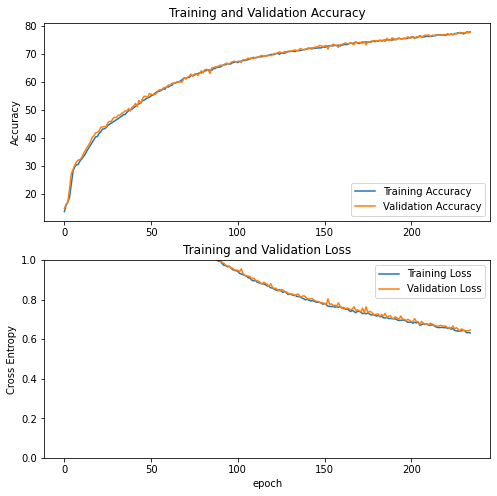

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Class accuracies using Validation Dataset**

In [18]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Tomato_Target_spot : 75 %
Accuracy of Tomato__Late_blight : 63 %
Accuracy of Tomato__Septoria_leaf_spot : 77 %
Accuracy of Tomato__Spider_mites : 72 %
Accuracy of Tomato___Bacterial_spot : 94 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 90 %
Accuracy of Tomato__early_blight : 68 %
Accuracy of Tomato__healthy : 86 %


**Class Accuracies using Test Dataset**

In [19]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Tomato_Target_spot : 73 %
Accuracy of Tomato__Late_blight : 58 %
Accuracy of Tomato__Septoria_leaf_spot : 76 %
Accuracy of Tomato__Spider_mites : 65 %
Accuracy of Tomato___Bacterial_spot : 90 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 91 %
Accuracy of Tomato__early_blight : 63 %
Accuracy of Tomato__healthy : 87 %


In [20]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/8
print('Average accuracy = ', avg)

Average accuracy =  75.91931713247286


**Confusion Matrix using Validation Dataset:**

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.7)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a validation set is: 19488
The number of images in a test set is: 5856
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


[[1780   11   84  183   24   10  119  143]
 [  35 1526  162  105  101   84  373   27]
 [ 109  107 1770   66   58   22  172   84]
 [ 330   25  105 1595    7   56  178   37]
 [   7   36    6    1 2449   76   14    0]
 [   2   31    1   20  135 2366   31    0]
 [ 174  257   87   98  108   66 1612   18]
 [ 121   19   21   51   54    0    1 2131]]
[75.61597281 63.24077911 74.12060302 68.36690956 94.59250676 91.49265275
 66.61157025 88.86572143]


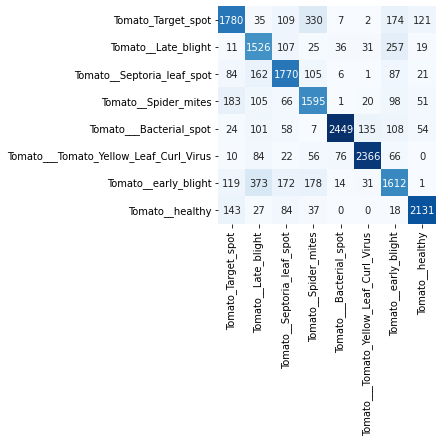

In [27]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)

**Confusion Matrix using Test Dataset:**

[[548   3  19  61   6   4  31  51]
 [ 15 472  52  31  25  23 100  13]
 [ 39  27 540  23  12   8  45  23]
 [109   7  25 471   1  17  48  15]
 [  1  10   4   1 733  22   5   0]
 [  0   4   0   4  42 716   7   0]
 [ 53  70  26  28  35  28 496   4]
 [ 34   2   4  13  23   0   0 616]]
[75.79529737 64.56908345 75.31380753 67.96536797 94.45876289 92.62613195
 67.02702703 89.01734104]


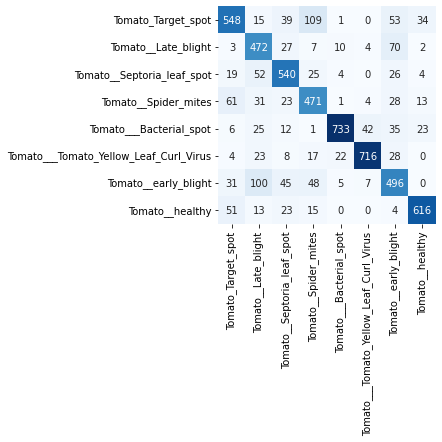

In [28]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes,  cmap='Blues', fmt='d', cbar=False)